In [1]:
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from matplotlib import pyplot
import matplotlib.cm as cm

plt.style.use(style="seaborn")
%matplotlib inline

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/nsethi4310/CoffeeMLProject3/main/Resources/Coffee_Price_Data%20.csv")

In [3]:
df.head(5)

,Date,ICO Composite Price,Colombian\n Milds,Other Milds,Brazilian\n Naturals,Robustas
0,01/01/1990,62.75,82.07,76.02,70.36,49.47
1,02/01/1990,67.01,91.55,83.95,77.59,50.06
2,03/01/1990,75.25,103.24,94.73,86.17,55.76
3,04/01/1990,75.34,101.79,94.71,87.45,55.95
4,05/01/1990,73.30,99.14,92.97,86.31,53.62


(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

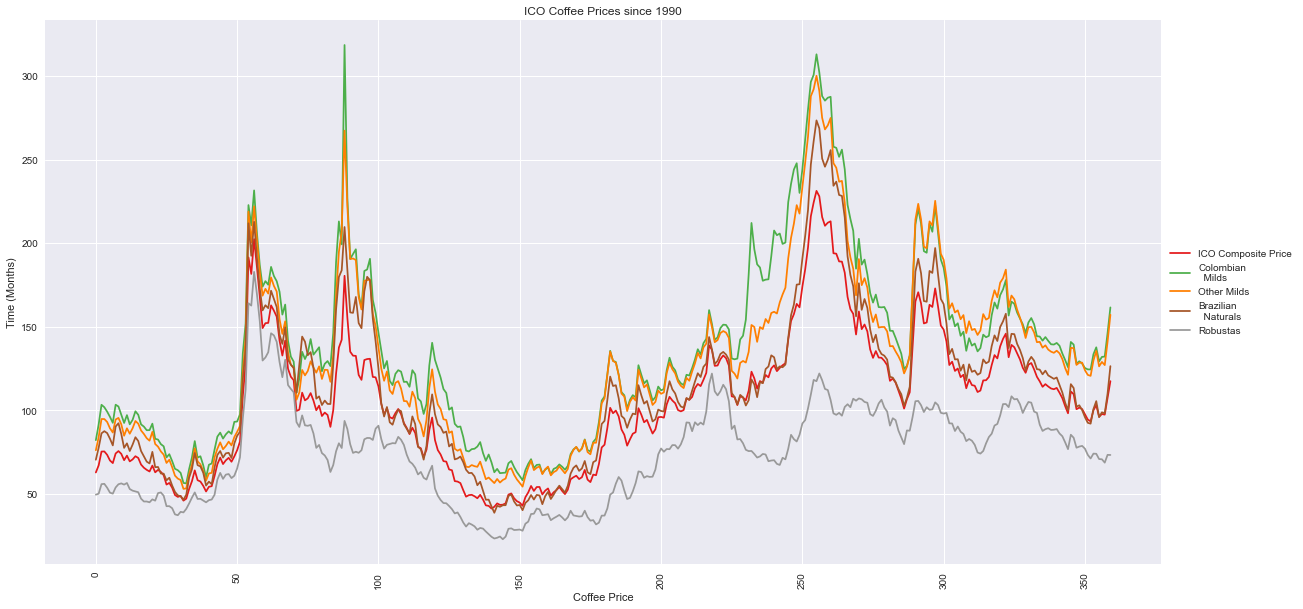

In [4]:
df.plot(kind='line', cmap=cm.Set1, figsize=(20, 10))
plt.title("ICO Coffee Prices since 1990")
plt.xlabel("Coffee Price")
plt.ylabel("Time (Months)")
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)

In [5]:
df_ICO = df[["ICO Composite Price"]].copy()

In [6]:
df_ICO.head(5)

,ICO Composite Price
0,62.75
1,67.01
2,75.25
3,75.34
4,73.30


#### Transform this to a supervised learning problem.

In [7]:
df_ICO["target"] = df_ICO['ICO Composite Price'].shift(-1)

In [8]:
df_ICO.dropna(inplace=True)

In [9]:
df_ICO.head(5)

,ICO Composite Price,target
0,62.75,67.01
1,67.01,75.25
2,75.25,75.34
3,75.34,73.30
4,73.30,69.91


#### Train test split

In [10]:
def train_test_split(data, perc):
    data = data.values
    n = int(len(data) * (1 - perc))
    return data[:n], data[n:]

In [11]:
train, test = train_test_split(df_ICO, 0.2)

In [12]:
print(len(df_ICO))
print(len(train))
print(len(test))

359
287
72


In [13]:
X = train[:, :-1]
y = train[:, -1] 

In [14]:
len(X)

287

In [15]:
from xgboost import XGBRegressor

model = XGBRegressor(objective="reg:squarederror", n_estimators=1000, num_features=1)
model.fit(X, y)

[09:40:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { num_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_features=1, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [16]:
test[0]

array([106.56, 110.75])

In [18]:
val = np.array(test[0, 0]).reshape(1, -1)
pred = model.predict(val)
print(pred[0])

107.976944


In [19]:
def xgb_predict(train, val):
    train = np.array(train)
    X, y = train[:, :-1], train[:, -1]
    model = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
    model.fit(X, y)

    val = np.array(val).reshape(1, -1)
    pred = model.predict(val)
    return pred[0]

In [20]:
xgb_predict(train, test[0, 0])

107.976944

In [21]:
from sklearn.metrics import mean_squared_error


def validate(data, perc):
    predictions = []

    train, test = train_test_split(data, perc)

    history = [x for x in train]

    for i in range(len(test)):
        test_X, test_y = test[i, :-1], test[i, -1]

        pred = xgb_predict(history, test_X[0])
        predictions.append(pred)

        history.append(test[i])

    error = mean_squared_error(test[:, -1], predictions, squared=False)

    return error, test[:, -1], predictions

In [22]:
%%time
rmse, y, pred = validate(df_ICO, 0.2)
print(rmse)

/Users/michelledavis/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/xgboost/data.py:107: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


11.516529850073178
CPU times: user 5min 18s, sys: 4.67 s, total: 5min 23s
Wall time: 50.7 s


In [29]:
pred_df = pd.DataFrame(pred)

In [31]:
pred_df.to_csv('Data/pred.csv')

In [32]:
y_df = pd.DataFrame(y)

In [33]:
y_df.to_csv('Data/y.csv')

In [34]:
heatmap_df = pd.read_csv('Data/Test Data Heatmap.csv')

In [36]:
import plotly.express as px
fig = px.density_heatmap(heatmap_df, x="Test Values", y="Predictions", template="seaborn", title="ICO Composite Price Actual vs. Predictions")
fig.show()

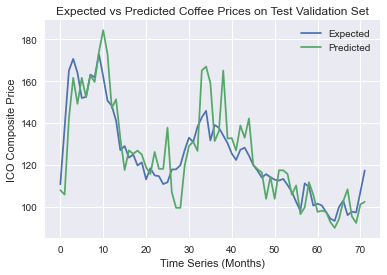

In [177]:
pyplot.plot(y, label='Expected')
pyplot.plot(pred, label='Predicted')
pyplot.legend()
pyplot.xlabel('Time Series (Months)')
pyplot.ylabel('ICO Composite Price')
pyplot.title('Expected vs Predicted Coffee Prices on Test Validation Set')
pyplot.show()

Colombian Mild Coffee 

In [47]:
df_colombian = df[["Colombian\n  Milds"]].copy()

In [48]:
df_colombian["target"] = df_colombian['Colombian\n  Milds'].shift(-1)

In [49]:
df_colombian.dropna(inplace=True)

In [50]:
df_colombian.head()

,Colombian\n Milds,target
0,82.07,91.55
1,91.55,103.24
2,103.24,101.79
3,101.79,99.14
4,99.14,96.01


In [51]:
train, test = train_test_split(df_colombian, 0.2)

In [ ]:
X = train[:, :-1]
y = train[:, -1] 

In [52]:
%%time
rmse, y, pred = validate(df_colombian, 0.2)

print(rmse)

/Users/michelledavis/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/xgboost/data.py:107: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


17.30418518700958
CPU times: user 10min 29s, sys: 32.4 s, total: 11min 2s
Wall time: 2min 5s


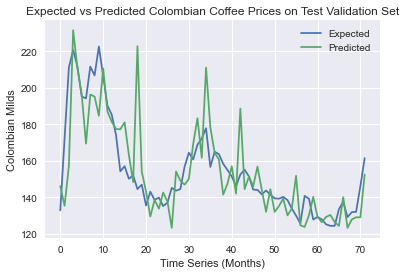

In [53]:
pyplot.plot(y, label='Expected')
pyplot.plot(pred, label='Predicted')
pyplot.legend()
pyplot.xlabel('Time Series (Months)')
pyplot.ylabel('Colombian Milds')
pyplot.title('Expected vs Predicted Colombian Coffee Prices on Test Validation Set')
pyplot.show()

In [110]:
df_brazil = df[["Brazilian\n  Naturals"]].copy()

In [111]:
df_brazil["target"] = df_brazil['Brazilian\n  Naturals'].shift(-1)

In [112]:
df_brazil.dropna(inplace=True)

In [113]:
df_brazil.head()

,Brazilian\n Naturals,target
0,70.36,77.59
1,77.59,86.17
2,86.17,87.45
3,87.45,86.31
4,86.31,82.94


In [114]:
train, test = train_test_split(df_brazil, 0.2)

In [115]:
X = train[:, :-1]
y = train[:, -1] 

In [116]:
%%time
rmse, y, pred = validate(df_brazil, 0.2)

print(rmse)

/Users/michelledavis/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/xgboost/data.py:107: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


13.327773185963347
CPU times: user 10min 33s, sys: 24.8 s, total: 10min 58s
Wall time: 2min 2s


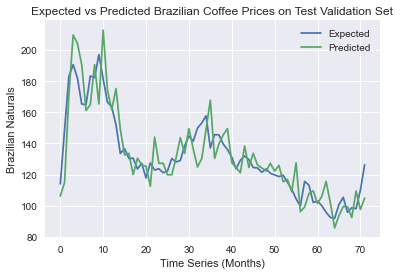

In [117]:
pyplot.plot(y, label='Expected')
pyplot.plot(pred, label='Predicted')
pyplot.legend()
pyplot.xlabel('Time Series (Months)')
pyplot.ylabel('Brazilian Naturals')
pyplot.title('Expected vs Predicted Brazilian Coffee Prices on Test Validation Set')
pyplot.show()

In [148]:
df_robustas = df[["Robustas"]].copy()

In [149]:
df_robustas["target"] = df_robustas['Robustas'].shift(-1)

In [150]:
df_robustas.dropna(inplace=True)

In [151]:
train, test = train_test_split(df_brazil, 0.2)

In [152]:
X = train[:, :-1]
y = train[:, -1] 

In [153]:
%%time
rmse, y, pred = validate(df_robustas, 0.2)

print(rmse)

/Users/michelledavis/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/xgboost/data.py:107: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


5.629823658901597
CPU times: user 10min 4s, sys: 21.1 s, total: 10min 25s
Wall time: 1min 55s


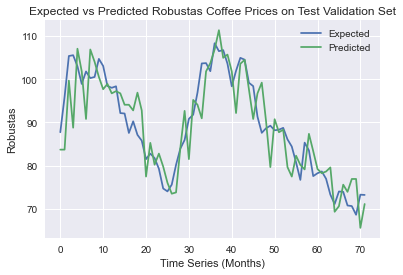

In [154]:
pyplot.plot(y, label='Expected')
pyplot.plot(pred, label='Predicted')
pyplot.legend()
pyplot.xlabel('Time Series (Months)')
pyplot.ylabel('Robustas')
pyplot.title('Expected vs Predicted Robustas Coffee Prices on Test Validation Set')
pyplot.show()

In [178]:
df_othermilds = df[["Other Milds"]].copy()

In [179]:
df_othermilds["target"] = df_othermilds['Other Milds'].shift(-1)

In [180]:
df_othermilds.dropna(inplace=True)

In [181]:
train, test = train_test_split(df_othermilds, 0.2)

In [182]:
X = train[:, :-1]
y = train[:, -1] 

In [183]:
%%time
rmse, y, pred = validate(df_othermilds, 0.2)

print(rmse)

/Users/michelledavis/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/xgboost/data.py:107: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


13.034281484733246
CPU times: user 7min 56s, sys: 17.4 s, total: 8min 13s
Wall time: 1min 31s


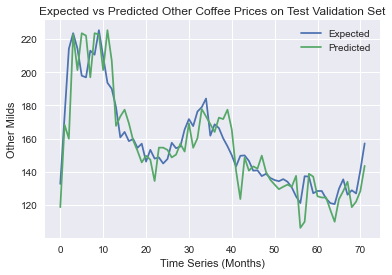

In [184]:
pyplot.plot(y, label='Expected')
pyplot.plot(pred, label='Predicted')
pyplot.legend()
pyplot.xlabel('Time Series (Months)')
pyplot.ylabel('Other Milds')
pyplot.title('Expected vs Predicted Other Coffee Prices on Test Validation Set')
pyplot.show()